This is my notebook for classical Kaggle Titanic competition. In this competition participants use machine learning to create a model that predicts which passengers survived the Titanic shipwreck.

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
from scipy import stats as st
from scipy.stats import chi2_contingency, spearmanr


from catboost import CatBoostClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.tree import plot_tree
from sklearn.metrics import RocCurveDisplay, roc_curve, auc

from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve 
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

from sklearn.metrics import accuracy_score, precision_recall_curve, classification_report, fbeta_score, make_scorer

In [2]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 12,8

## Loading Datasets

In [3]:
df = pd.read_csv('train.csv', index_col='PassengerId')

In [4]:
df_test = pd.read_csv('test.csv', index_col='PassengerId')

In [5]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       332 non-null    float64
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      417 non-null    float64
 8   Cabin     91 non-null     object 
 9   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 35.9+ KB


| Variable |	Definition |	Key |
| --- | --- | --- |
survival |	Survival |	0 = No, 1 = Yes |
pclass |	Ticket class |	1 = 1st, 2 = 2nd, 3 = 3rd |
sex |	Sex	||
Age |	Age in years	||
sibsp	| # of siblings / spouses aboard the Titanic	||
parch	| # of parents / children aboard the Titanic	||
ticket	| Ticket number	||
fare	| Passenger fare	||
cabin	| Cabin number	||
embarked	| Port of Embarkation	| C = Cherbourg, Q = Queenstown, S = Southampton |

## Analysis

### Functions

In [8]:
alpha = 0.05
def ttest_res(col):
    
    mean_gone = df.query('Survived == 1')[col].mean()
    mean_not_gone = df.query('Survived == 0')[col].mean()
    print('Mean of survived passengers', mean_gone)
    print('Mean of dead passengers', mean_not_gone)
    results = st.ttest_ind(df.query('Survived == 1')[col].dropna(), df.query('Survived == 0')[col].dropna())
    print('p-value: ', results.pvalue)

    if results.pvalue < alpha:
        print("Reject the null hypothesis")
    else:
        print("Fail to reject the null hypothesis")

In [9]:
alpha = 0.05
def table_for_chi2(col_group):
    table1 = df.groupby(col_group, as_index=False)['Survived'].sum()
    table2 = df.groupby(col_group, as_index=False)['Name'].count()
    merge = table1.merge(table2, on=col_group)
    merge.rename(columns = {'Name':'All'}, inplace = True)
    merge['Not_survived'] = merge['All'] - merge['Survived']
    merge = merge.drop('All', axis=1)
        
    stat, p, dof, expected = chi2_contingency(merge[['Survived', 'Not_survived']])
      
    return merge, p

In [10]:
def chi2_display_res(merge, p, alpha):
    display(merge)
    print('p-value:', p)
    if p < alpha:
        print('Reject the null hypothesis')
    else:
        print('Fail to reject the null hypothesis')

In [11]:
def pie_plot(title, col):
    fig = plt.figure()
    plt.title(title)
    plt.axis('off')

    labels = df.query('Survived == 0')[col].value_counts().index.tolist()
    ax1 = fig.add_axes([0, .3, 0.5, .5], aspect=1)
    fracs = df.query('Survived == 0')[col].value_counts().values
    ax1.pie(fracs, labels=labels, radius = 1.2, startangle=90, autopct='%1.1f%%')
    ax1.set_xlabel('Dead passengers')

    labels = df.query('Survived == 1')[col].value_counts().index.tolist()
    ax2 = fig.add_axes([.5, .3, 0.5, .5], aspect=1)
    fracs = df.query('Survived == 1')[col].value_counts().values
    ax2.pie(fracs, labels=labels, radius = 1.2, startangle=90, autopct='%1.1f%%')
    ax2.set_xlabel('Survived passengers')

    plt.show()

### Target Feature - Survived

/home/alena/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


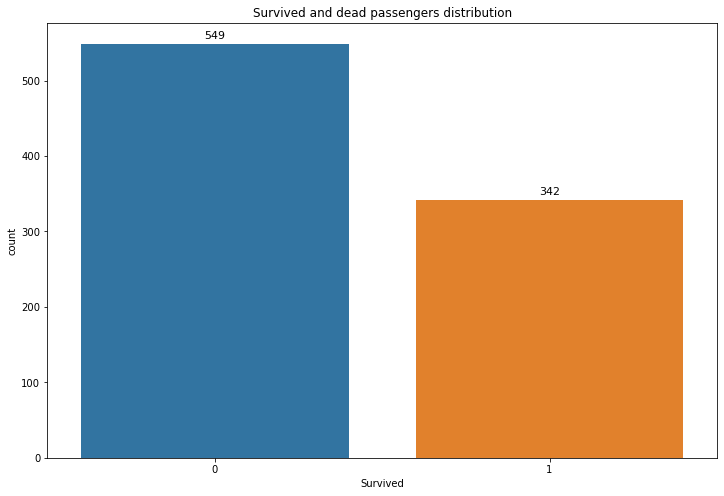

In [12]:
count = sns.countplot(df['Survived'])
for bar in count.patches:
        count.annotate(format(bar.get_height()),
            (bar.get_x() + bar.get_width() / 2,
            bar.get_height()), ha='center', va='center',
            size=11, xytext=(0, 8),
            textcoords='offset points')
plt.title('Survived and dead passengers distribution')
plt.show()

In [13]:
df['Survived'].value_counts(normalize=True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

38% of passengers didn't survive.

### Class

In [14]:
df['Pclass'].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

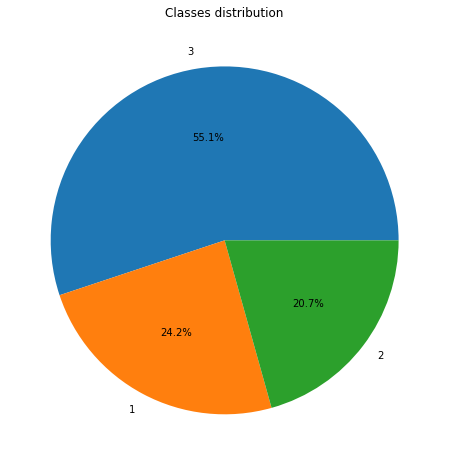

In [15]:
labels = df['Pclass'].value_counts().index.tolist()
fracs = df['Pclass'].value_counts().values
plt.pie(fracs, labels=labels, autopct='%1.1f%%')
plt.title('Classes distribution')
plt.show()

/home/alena/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


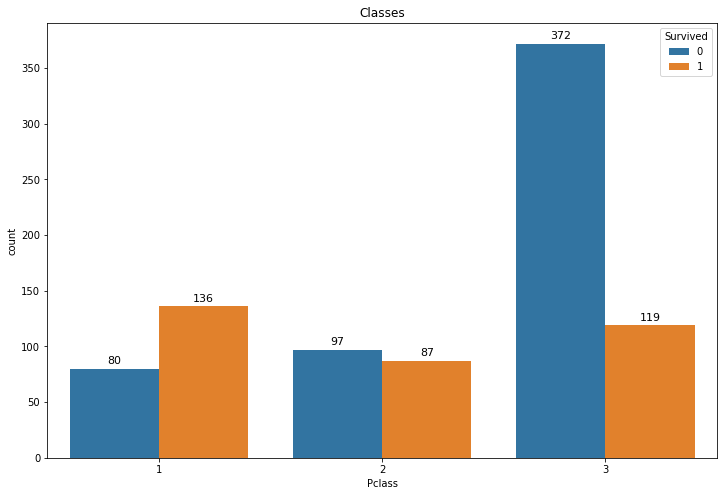

In [16]:
count = sns.countplot(df['Pclass'], hue=df['Survived'])
for bar in count.patches:
        count.annotate(format(bar.get_height()),
            (bar.get_x() + bar.get_width() / 2,
            bar.get_height()), ha='center', va='center',
            size=11, xytext=(0, 8),
            textcoords='offset points')
plt.title('Classes')
plt.show()

In [17]:
chi2_display_res(*table_for_chi2('Pclass'), alpha)

,Pclass,Survived,Not_survived
0,1,136,80
1,2,87,97
2,3,119,372


p-value: 4.5492517112987287e-23
Reject the null hypothesis


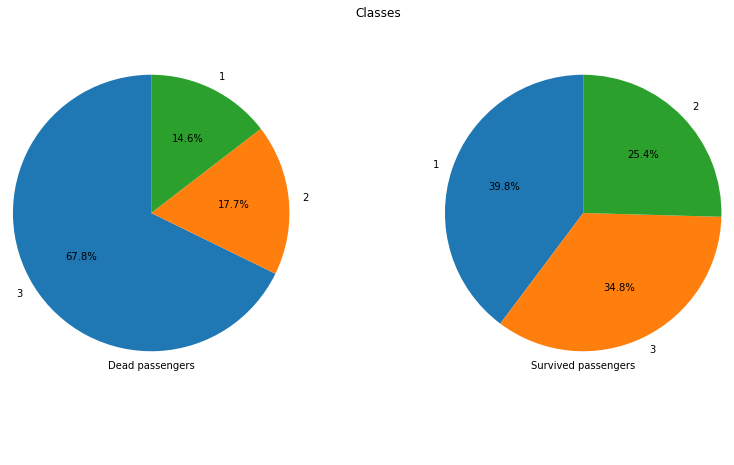

In [18]:
pie_plot('Classes', 'Pclass')

In [19]:
surv_class = df.pivot_table(index='Pclass', columns='Survived', values='Name', aggfunc='count')
surv_class['Percentage of survived'] = surv_class[1] / (surv_class[0] + surv_class[1])
surv_class

Survived,0,1,Percentage of survived
Pclass,,,
1,80,136,0.629630
2,97,87,0.472826
3,372,119,0.242363


There were 216 (24.2%) of the first class passengers, 184 (20.7%) of the second class passengers and 491 (55.1%) of the third class passengers on the Titanic.

Passengers of the first class survived in 63% of cases, while passengers of the second class in 47%, and passengers of the third class in 24%.

### Sex

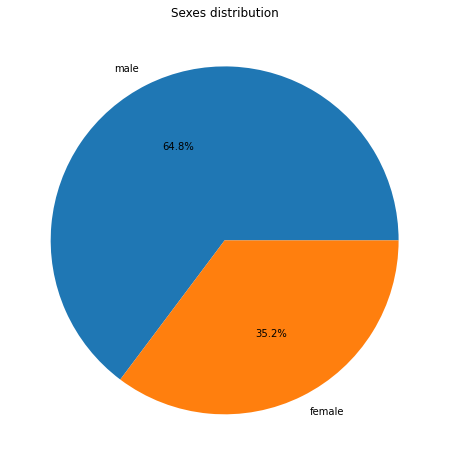

In [20]:
labels = df['Sex'].value_counts().index.tolist()
fracs = df['Sex'].value_counts().values
plt.pie(fracs, labels=labels, autopct='%1.1f%%')
plt.title('Sexes distribution')
plt.show()

/home/alena/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


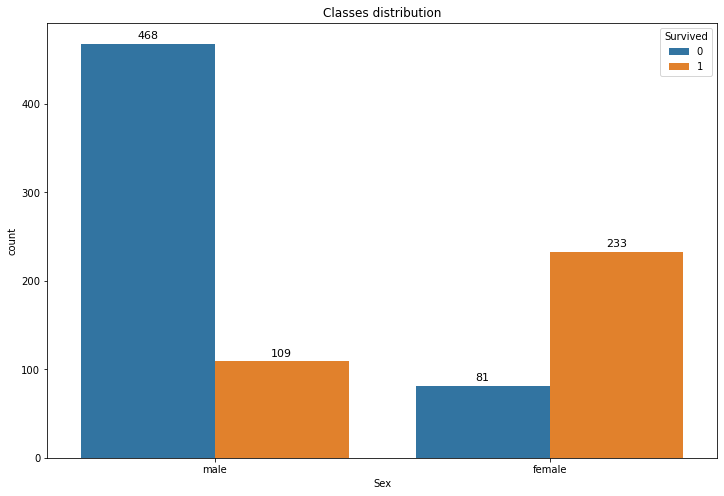

In [21]:
count = sns.countplot(df['Sex'], hue=df['Survived'])
for bar in count.patches:
    count.annotate(format(bar.get_height()),
            (bar.get_x() + bar.get_width() / 2,
            bar.get_height()), ha='center', va='center',
            size=11, xytext=(0, 8),
            textcoords='offset points')
plt.title('Classes distribution')
plt.show()

In [22]:
chi2_display_res(*table_for_chi2('Sex'), alpha)

,Sex,Survived,Not_survived
0,female,233,81
1,male,109,468


p-value: 1.1973570627755645e-58
Reject the null hypothesis


In [23]:
surv_sex = df.pivot_table(index='Sex', columns='Survived', values='Name', aggfunc='count')
surv_sex['Percentage of survived'] = surv_sex[1] / (surv_sex[0] + surv_sex[1])
surv_sex

Survived,0,1,Percentage of survived
Sex,,,
female,81,233,0.742038
male,468,109,0.188908


Most of passengers were men, but most of the survived were women. The survived in 74% of cases, while men only in 19%

### Age

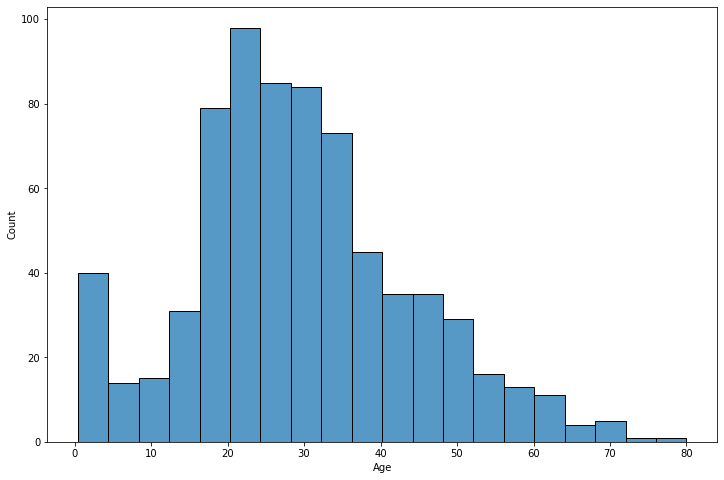

In [24]:
sns.histplot(df['Age'])
plt.show()

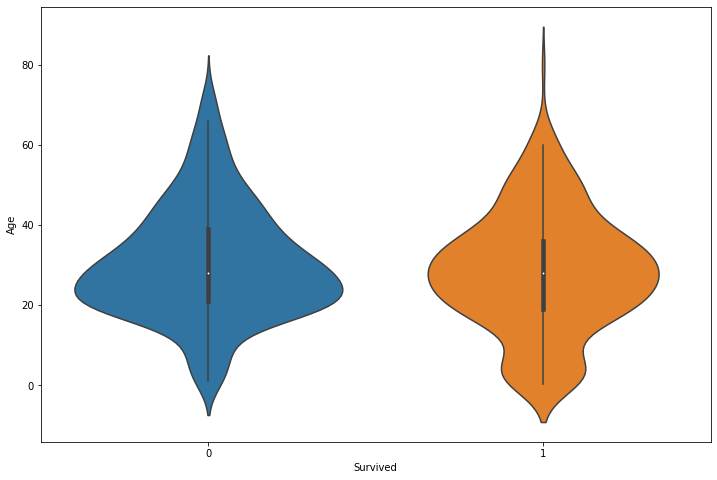

In [25]:
sns.violinplot(data=df, y='Age' , x='Survived')
plt.show()

In [26]:
ttest_res('Age')

Mean of survived passengers 28.343689655172415
Mean of dead passengers 30.62617924528302
p-value:  0.03912465401348249
Reject the null hypothesis


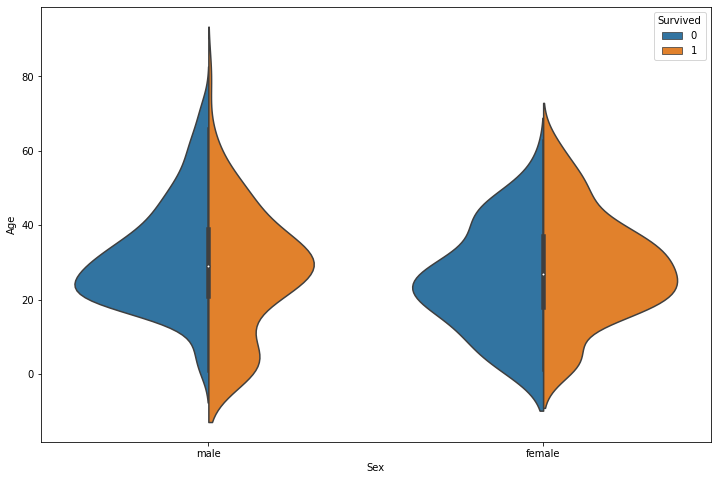

In [27]:
sns.violinplot(data=df, x="Sex", y="Age", hue="Survived", split=True)
plt.show()

Age of the passengers vary from almost newborn to 80 years. A lot of children survived, while passengers of middle age did not. Survival rate for boys is higher then for girls, and for old women higher then for old men.

### Siblings and Spouses

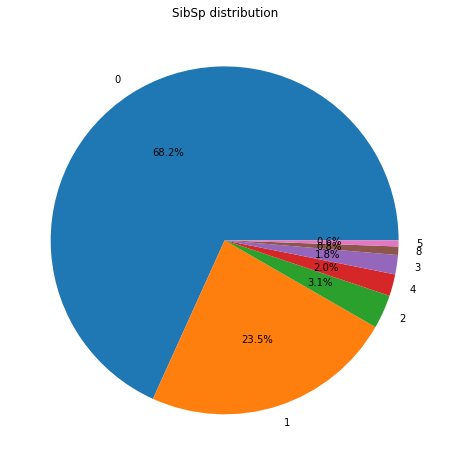

In [28]:
labels = df['SibSp'].value_counts().index.tolist()
fracs = df['SibSp'].value_counts().values
plt.pie(fracs, labels=labels, autopct='%1.1f%%')
plt.title('SibSp distribution')
plt.show()

/home/alena/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


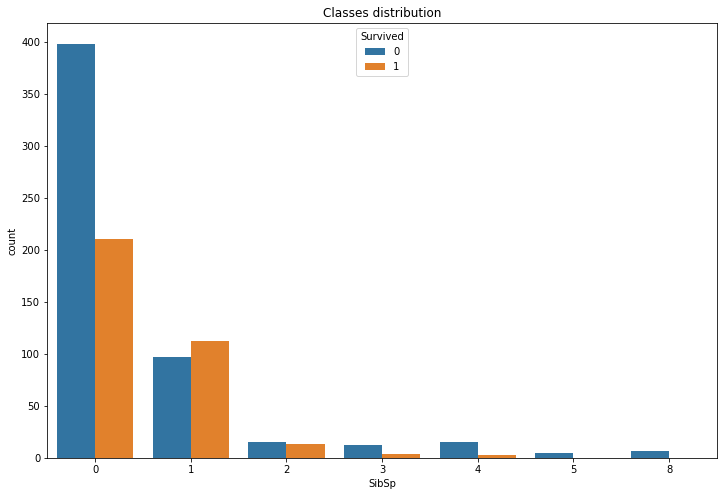

In [29]:
sns.countplot(df['SibSp'], hue=df['Survived'])
plt.title('Classes distribution')
plt.show()


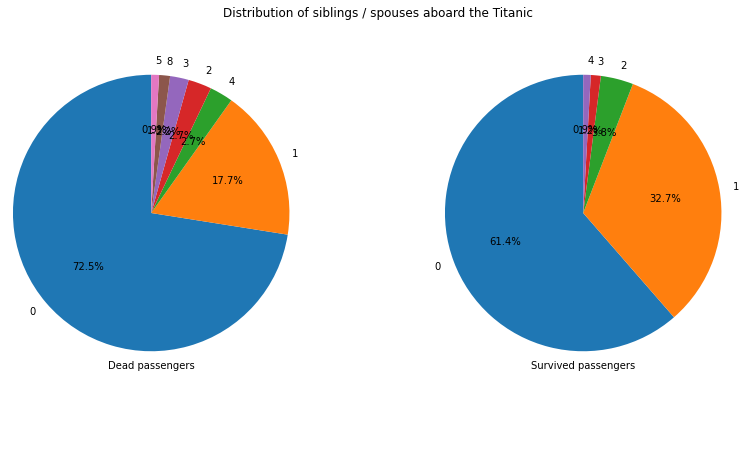

In [30]:
pie_plot('Distribution of siblings / spouses aboard the Titanic', 'SibSp')

In [31]:
chi2_display_res(*table_for_chi2('SibSp'), alpha)

,SibSp,Survived,Not_survived
0,0,210,398
1,1,112,97
2,2,13,15
3,3,4,12
4,4,3,15
5,5,0,5
6,8,0,7


p-value: 1.5585810465902116e-06
Reject the null hypothesis


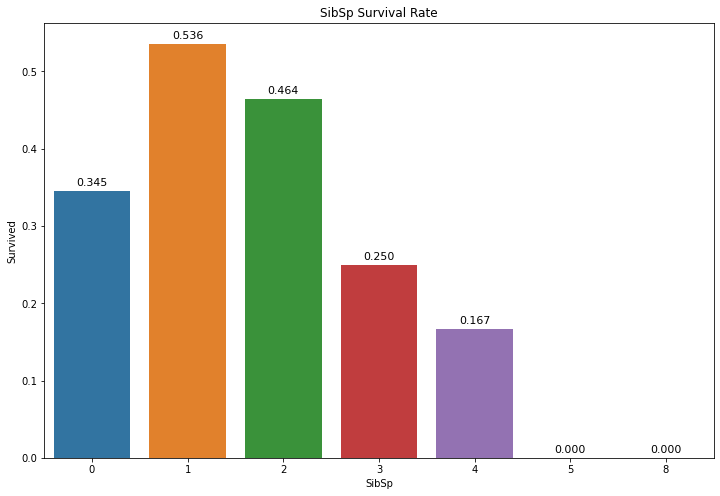

In [32]:
surv = sns.barplot(data=df, x='SibSp', y='Survived', ci=None)
for bar in surv.patches:
    surv.annotate(format("{:.3f}".format(bar.get_height())),
            (bar.get_x() + bar.get_width() / 2,
            bar.get_height()), ha='center', va='center',
            size=11, xytext=(0, 8),
            textcoords='offset points')
        
plt.title("SibSp Survival Rate")
plt.show()

Two thirds of passengers traveled alone. Passengers with small family numbers tends to survive in almost half of the cases, while lone passengers in 35% and passengers with family number > 4 didn't survive at all.

### Parents and Children

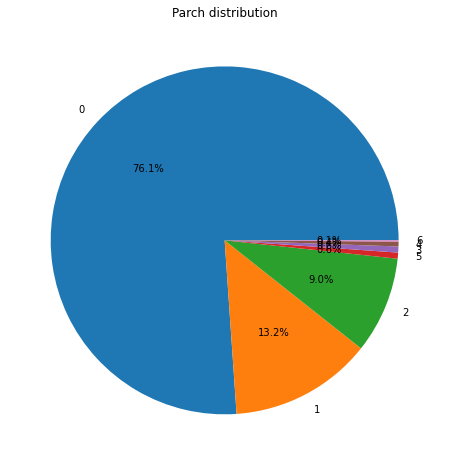

In [33]:
labels = df['Parch'].value_counts().index.tolist()
fracs = df['Parch'].value_counts().values
plt.pie(fracs, labels=labels, autopct='%1.1f%%')
plt.title('Parch distribution')
plt.show()

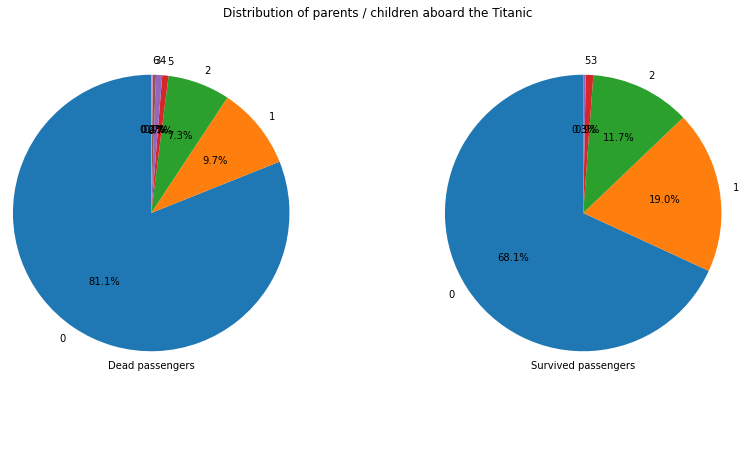

In [34]:
pie_plot('Distribution of parents / children aboard the Titanic', 'Parch')

In [35]:
chi2_display_res(*table_for_chi2('Parch'), alpha)

,Parch,Survived,Not_survived
0,0,233,445
1,1,65,53
2,2,40,40
3,3,3,2
4,4,0,4
5,5,1,4
6,6,0,1


p-value: 9.703526421039997e-05
Reject the null hypothesis


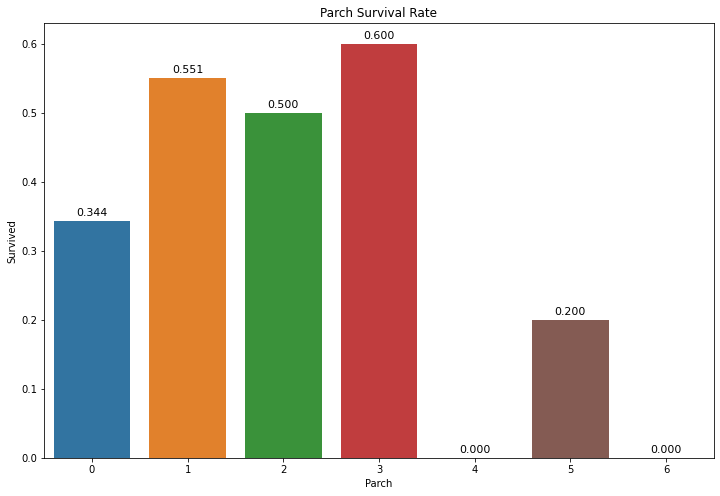

In [36]:
surv = sns.barplot(data=df, x='Parch', y='Survived', ci=None)
for bar in surv.patches:
    surv.annotate(format("{:.3f}".format(bar.get_height())),
            (bar.get_x() + bar.get_width() / 2,
            bar.get_height()), ha='center', va='center',
            size=11, xytext=(0, 8),
            textcoords='offset points')
        
plt.title("Parch Survival Rate")
plt.show()

Three fourth of passengers traveled without parents or children. Highest survival rate is for passengers with 1, 2 and 3 parents/children. Lone passengers survival rate is lower and passengers with parents/children > 3 almost didn't survive.

### Fare

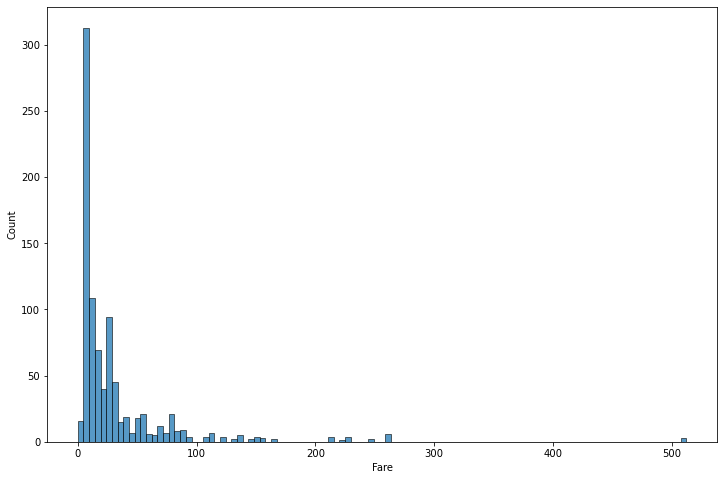

In [37]:
sns.histplot(df['Fare'])
plt.show()

On the plot we can see passengers who payed more than 500 dollars and who payed nothing. Let's look closer, maybe thats a mistake.

In [38]:
df[df['Fare'] > 300]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
259,1,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,NaN,C
680,1,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,PC 17755,512.3292,B51 B53 B55,C
738,1,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.3292,B101,C


In [39]:
df[df['Fare'] == 0]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,NaN,S
264,0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0,B94,S
272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,NaN,S
278,0,2,"Parkes, Mr. Francis ""Frank""",male,NaN,0,0,239853,0.0,NaN,S
303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,NaN,S
414,0,2,"Cunningham, Mr. Alfred Fleming",male,NaN,0,0,239853,0.0,NaN,S
467,0,2,"Campbell, Mr. William",male,NaN,0,0,239853,0.0,NaN,S
482,0,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0,NaN,S
598,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,NaN,S


Obviously there are no mistakes as the higest fare was for the first class passengers, and no fare was for crew members.

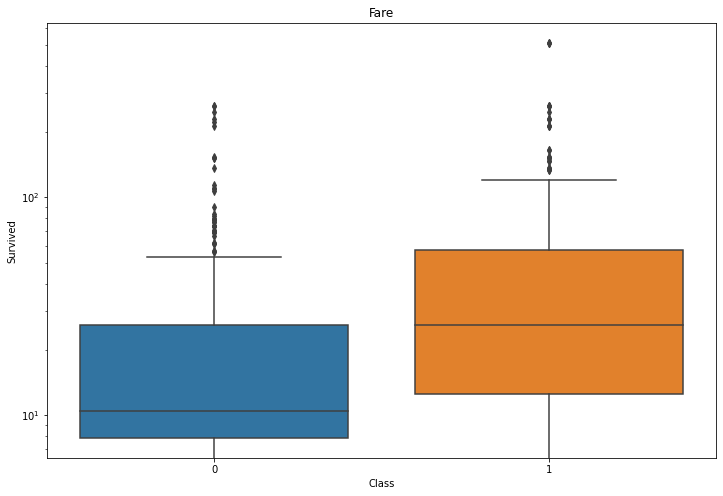

In [40]:
g = sns.boxplot(data=df, y='Fare' , x='Survived')
g.set_yscale("log")
_ = g.set(xlabel="Class", ylabel="Survived")
plt.title('Fare')
plt.show()

In [41]:
ttest_res('Fare')

Mean of survived passengers 48.39540760233917
Mean of dead passengers 22.117886885245877
p-value:  6.120189341924198e-15
Reject the null hypothesis


Fares stretch from 0 to 512 dollars, where 0 fare belongs to crew and the highest fare to the first class passengers. Passengers with greater fare survived more often.

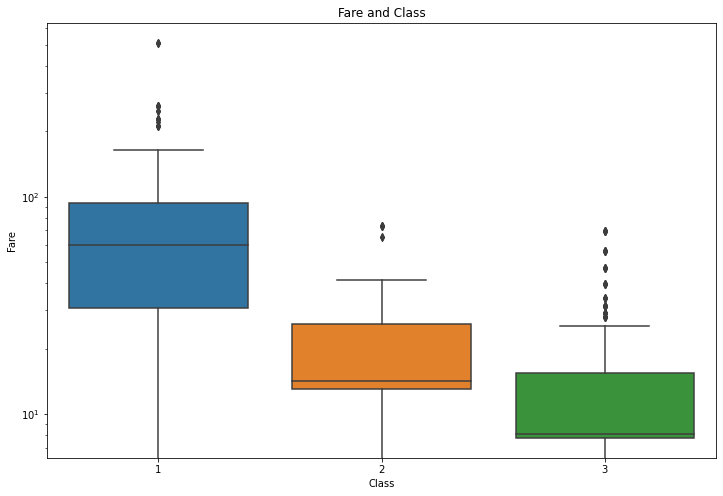

In [42]:
g = sns.boxplot(data=df, y='Fare' , x='Pclass')
g.set_yscale("log")
_ = g.set(xlabel="Class", ylabel="Fare")
plt.title('Fare and Class')
plt.show()

We can see that for the first class ticket passengers payed more then for second and much more then for the third. But there are some outliers, the passengers payed for low class ticket as for higher class. Maybe that's because they traveled more.

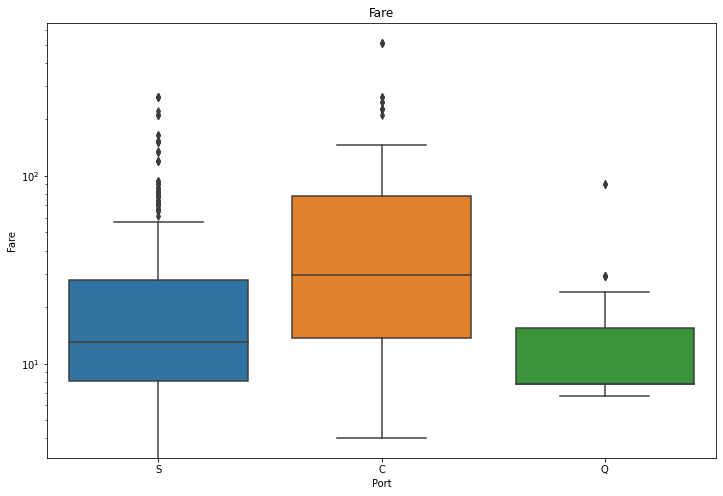

In [43]:
g = sns.boxplot(data=df, y='Fare' , x='Embarked')
g.set_yscale("log")
_ = g.set(xlabel="Port", ylabel="Fare")
plt.title('Fare')
plt.show()

The highest fare was for passengers embarked in Cherbourg although it was the middle point of the travel.

From Wikipedia:

920 passengers boarded Titanic at Southampton – 179 First Class, 247 Second Class, and 494 Third Class.

In Cherbourg 274 additional passengers were taken aboard – 142 First Class, 30 Second Class, and 102 Third Class.

123 passengers boarded Titanic at Queenstown – three First Class, seven Second Class and 113 Third Class.

### Port of Embarkation

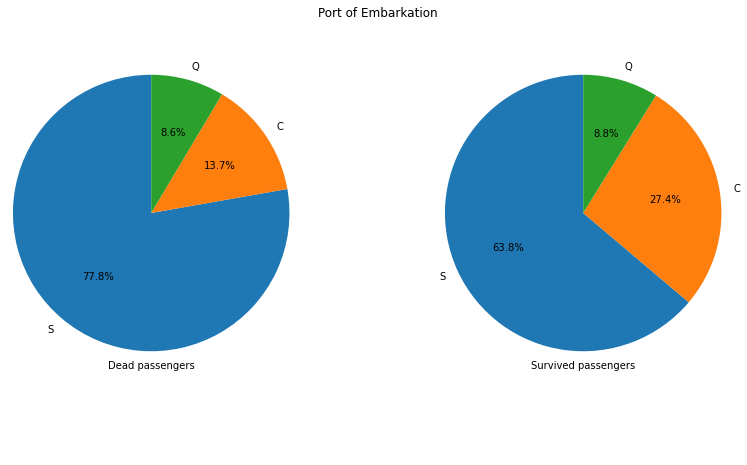

In [44]:
pie_plot('Port of Embarkation', 'Embarked')

In [45]:
chi2_display_res(*table_for_chi2('Embarked'), alpha)

,Embarked,Survived,Not_survived
0,C,93,75
1,Q,30,47
2,S,217,427


p-value: 1.769922284120912e-06
Reject the null hypothesis


In [46]:
surv_emb = df.pivot_table(index='Embarked', columns='Survived', values='Name', aggfunc='count')
surv_emb['Percentage of survived'] = surv_emb[1] / (surv_emb[0] + surv_emb[1])
surv_emb

Survived,0,1,Percentage of survived
Embarked,,,
C,75,93,0.553571
Q,47,30,0.389610
S,427,217,0.336957


Passengers taken aboard in Cherborg survived in more cases - maybe thats because there was a lot of the first class passengers?

## Creating New Features

In [47]:
combine = [df, df_test]

### Title

In [48]:
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(df['Title'], df['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [49]:
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(
        ['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


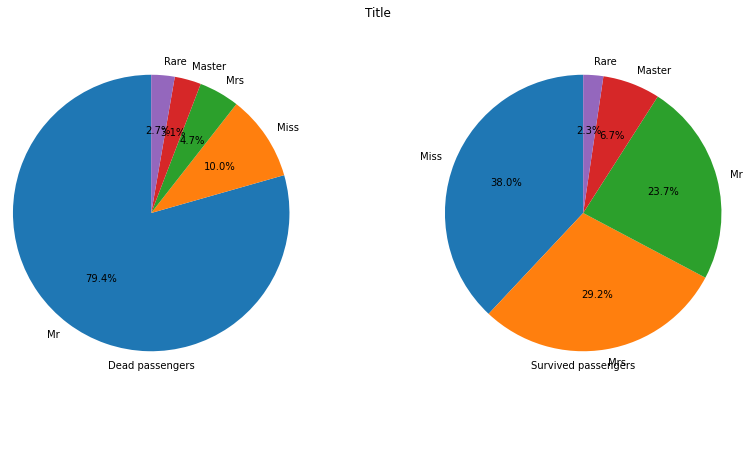

In [50]:
pie_plot('Title', 'Title')

<AxesSubplot:xlabel='Title', ylabel='Age'>

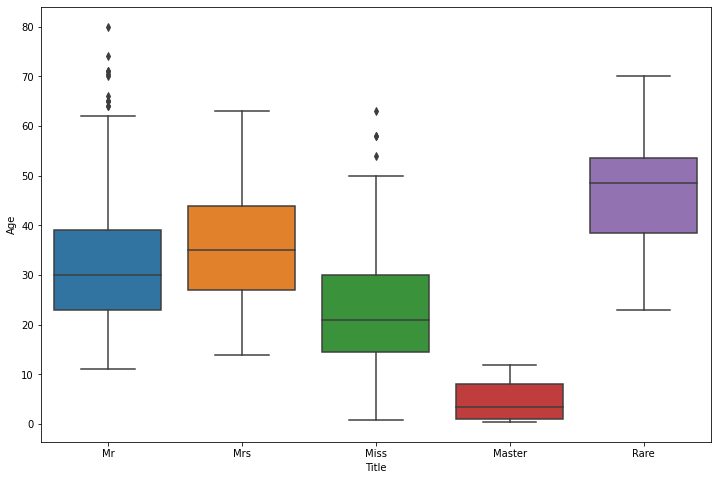

In [51]:
sns.boxplot(data=df, y='Age' , x='Title')

In [52]:
df.groupby(by='Title')['Age'].mean()

Title
Master     4.574167
Miss      21.845638
Mr        32.368090
Mrs       35.788991
Rare      45.545455
Name: Age, dtype: float64

In [53]:
for dataset in combine:
    dataset.loc[(dataset["Age"].isnull()) & (dataset["Title"]=='Master'), 'Age'] = 5
    dataset.loc[(dataset["Age"].isnull()) & (dataset["Title"]=='Miss'), 'Age'] = 22
    dataset.loc[(dataset["Age"].isnull()) & (dataset["Title"]=='Mr'), 'Age'] = 32
    dataset.loc[(dataset["Age"].isnull()) & (dataset["Title"]=='Mrs'), 'Age'] = 36
    dataset.loc[(dataset["Age"].isnull()) & (dataset["Title"]=='Rare'), 'Age'] = 45

In [54]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       418 non-null    float64
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      417 non-null    float64
 8   Cabin     91 non-null     object 
 9   Embarked  418 non-null    object 
 10  Title     418 non-null    object 
dtypes: float64(2), int64(3), object(6)
memory usage: 39.2+ KB


In [55]:
df['AgeBand'] = pd.cut(df['Age'], 5)
df[['AgeBand', 'Survived']].groupby(
    ['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)

,AgeBand,Survived
0,"(0.34, 16.336]",0.548077
1,"(16.336, 32.252]",0.327345
2,"(32.252, 48.168]",0.436893
3,"(48.168, 64.084]",0.434783
4,"(64.084, 80.0]",0.090909


In [56]:
for dataset in combine:    
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,AgeBand
PassengerId,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,1.0,1,0,A/5 21171,7.2500,NaN,S,Mr,"(16.336, 32.252]"
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,2.0,1,0,PC 17599,71.2833,C85,C,Mrs,"(32.252, 48.168]"
3,1,3,"Heikkinen, Miss. Laina",female,1.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,"(16.336, 32.252]"
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,2.0,1,0,113803,53.1000,C123,S,Mrs,"(32.252, 48.168]"
5,0,3,"Allen, Mr. William Henry",male,2.0,0,0,373450,8.0500,NaN,S,Mr,"(32.252, 48.168]"


In [57]:
df = df.drop(['AgeBand'], axis=1)
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
PassengerId,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,1.0,1,0,A/5 21171,7.2500,NaN,S,Mr
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,2.0,1,0,PC 17599,71.2833,C85,C,Mrs
3,1,3,"Heikkinen, Miss. Laina",female,1.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,2.0,1,0,113803,53.1000,C123,S,Mrs
5,0,3,"Allen, Mr. William Henry",male,2.0,0,0,373450,8.0500,NaN,S,Mr


In [58]:
df_test.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
PassengerId,,,,,,,,,,,
892,3,"Kelly, Mr. James",male,2.0,0,0,330911,7.8292,NaN,Q,Mr
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,2.0,1,0,363272,7.0000,NaN,S,Mrs
894,2,"Myles, Mr. Thomas Francis",male,3.0,0,0,240276,9.6875,NaN,Q,Mr
895,3,"Wirz, Mr. Albert",male,1.0,0,0,315154,8.6625,NaN,S,Mr
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,1.0,1,1,3101298,12.2875,NaN,S,Mrs


In [59]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
PassengerId,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,1.0,1,0,A/5 21171,7.2500,NaN,S,Mr
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,2.0,1,0,PC 17599,71.2833,C85,C,Mrs
3,1,3,"Heikkinen, Miss. Laina",female,1.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,2.0,1,0,113803,53.1000,C123,S,Mrs
5,0,3,"Allen, Mr. William Henry",male,2.0,0,0,373450,8.0500,NaN,S,Mr


### Family Size

In [60]:
combine = [df, df_test]
for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    
df[['FamilySize', 'Survived']].groupby(
    ['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


### Is Alone

In [61]:
for dataset in combine:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

df[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


In [62]:
freq_port = df.Embarked.dropna().mode()[0]
freq_port

'S'

In [63]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)

df[['Embarked', 'Survived']].groupby(
    ['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


In [64]:
df_test['Fare'].fillna(df_test['Fare'].dropna().median(), inplace=True)
df_test.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize,IsAlone
PassengerId,,,,,,,,,,,,,
892,3,"Kelly, Mr. James",male,2.0,0,0,330911,7.8292,NaN,Q,Mr,1,1
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,2.0,1,0,363272,7.0000,NaN,S,Mrs,2,0
894,2,"Myles, Mr. Thomas Francis",male,3.0,0,0,240276,9.6875,NaN,Q,Mr,1,1
895,3,"Wirz, Mr. Albert",male,1.0,0,0,315154,8.6625,NaN,S,Mr,1,1
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,1.0,1,1,3101298,12.2875,NaN,S,Mrs,3,0


In [65]:
df['FareBand'] = pd.qcut(df['Fare'], 4)
df[['FareBand', 'Survived']].groupby(
    ['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)

,FareBand,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


In [66]:
combine = [df, df_test]
for dataset in combine:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

df = df.drop(['FareBand'], axis=1)

    
df.head(10)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize,IsAlone
PassengerId,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,1.0,1,0,A/5 21171,0,NaN,S,Mr,2,0
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,2.0,1,0,PC 17599,3,C85,C,Mrs,2,0
3,1,3,"Heikkinen, Miss. Laina",female,1.0,0,0,STON/O2. 3101282,1,NaN,S,Miss,1,1
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,2.0,1,0,113803,3,C123,S,Mrs,2,0
5,0,3,"Allen, Mr. William Henry",male,2.0,0,0,373450,1,NaN,S,Mr,1,1
6,0,3,"Moran, Mr. James",male,1.0,0,0,330877,1,NaN,Q,Mr,1,1
7,0,1,"McCarthy, Mr. Timothy J",male,3.0,0,0,17463,3,E46,S,Mr,1,1
8,0,3,"Palsson, Master. Gosta Leonard",male,0.0,3,1,349909,2,NaN,S,Master,5,0
9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,1.0,0,2,347742,1,NaN,S,Mrs,3,0


### Age x Class

In [67]:
combine = [df, df_test]
for dataset in combine:
    dataset['Age*Class'] = dataset.Age * dataset.Pclass

In [68]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize,IsAlone,Age*Class
PassengerId,,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,1.0,1,0,A/5 21171,0,NaN,S,Mr,2,0,3.0
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,2.0,1,0,PC 17599,3,C85,C,Mrs,2,0,2.0
3,1,3,"Heikkinen, Miss. Laina",female,1.0,0,0,STON/O2. 3101282,1,NaN,S,Miss,1,1,3.0
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,2.0,1,0,113803,3,C123,S,Mrs,2,0,2.0
5,0,3,"Allen, Mr. William Henry",male,2.0,0,0,373450,1,NaN,S,Mr,1,1,6.0


In [69]:
df_test.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize,IsAlone,Age*Class
PassengerId,,,,,,,,,,,,,,
892,3,"Kelly, Mr. James",male,2.0,0,0,330911,0,NaN,Q,Mr,1,1,6.0
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,2.0,1,0,363272,0,NaN,S,Mrs,2,0,6.0
894,2,"Myles, Mr. Thomas Francis",male,3.0,0,0,240276,1,NaN,Q,Mr,1,1,6.0
895,3,"Wirz, Mr. Albert",male,1.0,0,0,315154,1,NaN,S,Mr,1,1,3.0
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,1.0,1,1,3101298,1,NaN,S,Mrs,3,0,3.0


## Preparing samples

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    int64  
 1   Pclass      891 non-null    int64  
 2   Name        891 non-null    object 
 3   Sex         891 non-null    object 
 4   Age         891 non-null    float64
 5   SibSp       891 non-null    int64  
 6   Parch       891 non-null    int64  
 7   Ticket      891 non-null    object 
 8   Fare        891 non-null    int64  
 9   Cabin       204 non-null    object 
 10  Embarked    891 non-null    object 
 11  Title       891 non-null    object 
 12  FamilySize  891 non-null    int64  
 13  IsAlone     891 non-null    int64  
 14  Age*Class   891 non-null    float64
dtypes: float64(2), int64(7), object(6)
memory usage: 143.7+ KB


In [71]:
df = df.drop(['Name', 'Ticket', 'Cabin', 'SibSp', 'Parch'], axis=1)

In [72]:
df_test = df_test.drop(['Name', 'Ticket', 'Cabin', 'SibSp', 'Parch'], axis=1)

In [73]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pclass      418 non-null    int64  
 1   Sex         418 non-null    object 
 2   Age         418 non-null    float64
 3   Fare        418 non-null    int64  
 4   Embarked    418 non-null    object 
 5   Title       418 non-null    object 
 6   FamilySize  418 non-null    int64  
 7   IsAlone     418 non-null    int64  
 8   Age*Class   418 non-null    float64
dtypes: float64(2), int64(4), object(3)
memory usage: 32.7+ KB


In [74]:
combine = [df, df_test]
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
for dataset in combine:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

In [75]:
df_test.head()

,Pclass,Sex,Age,Fare,Embarked,Title,FamilySize,IsAlone,Age*Class
PassengerId,,,,,,,,,
892,3,0,2.0,0,2,1,1,1,6.0
893,3,1,2.0,0,0,3,2,0,6.0
894,2,0,3.0,1,2,1,1,1,6.0
895,3,0,1.0,1,0,1,1,1,3.0
896,3,1,1.0,1,0,3,3,0,3.0


In [76]:
df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,FamilySize,IsAlone,Age*Class
PassengerId,,,,,,,,,,
1,0,3,0,1.0,0,0,1,2,0,3.0
2,1,1,1,2.0,3,1,3,2,0,2.0
3,1,3,1,1.0,1,0,2,1,1,3.0
4,1,1,1,2.0,3,0,3,2,0,2.0
5,0,3,0,2.0,1,0,1,1,1,6.0


In [77]:
features = df.drop(['Survived'], axis=1)
target = df['Survived']

In [78]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size = 0.25, random_state=12345)

In [79]:
scaler = StandardScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)
features_valid = scaler.transform(features_valid)

In [80]:
test_index = df_test.index.to_list()

In [81]:
df_test = scaler.transform(df_test)

## Модели

### Constant Model

In [82]:
pred_bl = [0] * target.shape[0]

auc_roc = roc_auc_score(target.values, pred_bl)
accuracy = accuracy_score(target.values, pred_bl)

print(f"roc_auc для константной модели: {auc_roc:.3f}")
print(f"accuracy для константной модели: {accuracy:.3f}")

roc_auc для константной модели: 0.500
accuracy для константной модели: 0.616


### Logistic Regression

In [83]:
logreg = LogisticRegression(random_state=12345, max_iter=500)
logreg.fit(features_train, target_train)

LogisticRegression(max_iter=500, random_state=12345)

In [84]:
answer = logreg.predict(features_valid)
probabilities_test = logreg.predict_proba(features_valid)
probabilities_one_test = probabilities_test[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_test)
print(f"Roc_auc of Decision Tree: {auc_roc:.3f}")
print(f'Accuracy: {accuracy_score(target_valid, answer):.3f}')

Roc_auc of Decision Tree: 0.829
Accuracy: 0.789


### Decision Tree

In [85]:
first_model = tree.DecisionTreeClassifier(random_state=12345)
first_model.fit(features_train, target_train)

DecisionTreeClassifier(random_state=12345)

In [86]:
answer = first_model.predict(features_valid)
probabilities_test = first_model.predict_proba(features_valid)
probabilities_one_test = probabilities_test[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_test)
print(f"Roc_auc of Decision Tree: {auc_roc:.3f}")
print(f'Accuracy: {accuracy_score(target_valid, answer):.3f}')

Roc_auc of Decision Tree: 0.772
Accuracy: 0.771


### Random Forest

In [87]:
grid={"max_depth":range(1, 10), "min_samples_split":range(2, 10, 2), "criterion":['gini', 'entropy']}
second_model=RandomForestClassifier(random_state=12345)
second_model_cv=GridSearchCV(second_model,grid,cv=5, scoring = 'accuracy')
second_model_cv.fit(features_train,target_train)

print("tuned hyperparameters :(best parameters) ",second_model_cv.best_params_)

print(f"Roc_auc of Decision Tree: {roc_auc_score(target_valid, probabilities_one_test):.3f}")
print("accuracy :",second_model_cv.best_score_)

tuned hyperparameters :(best parameters)  {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 2}
Roc_auc of Decision Tree: 0.772
accuracy : 0.8427673661766356


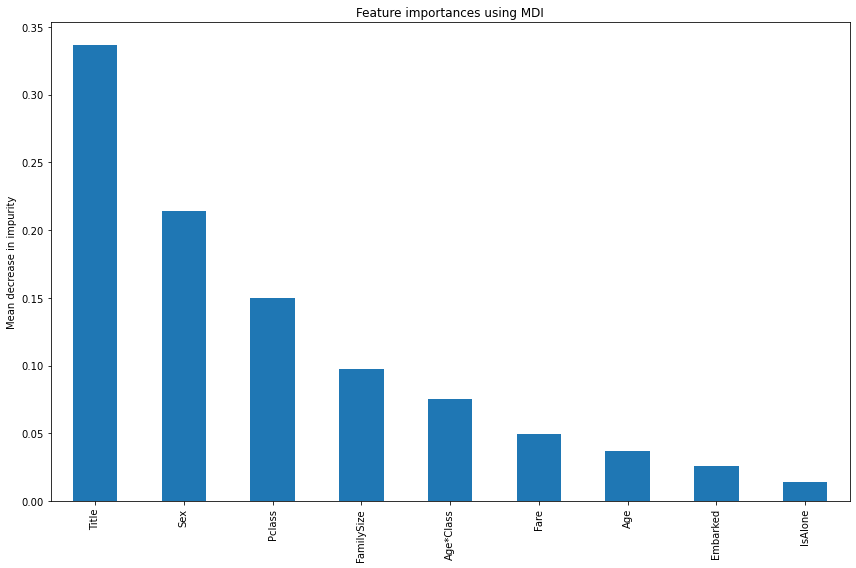

In [107]:
importances = second_model_cv.best_estimator_.feature_importances_

forest_importances = pd.Series(importances, index=features.columns)

fig, ax = plt.subplots()
forest_importances.sort_values(ascending=False).plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

### Cat Boost

In [97]:
catb = CatBoostClassifier(verbose=False)
fit_model = catb.fit(features_train, target_train)

In [98]:
answer = fit_model.predict(features_valid)
probabilities_test = fit_model.predict_proba(features_valid)
probabilities_one_test = probabilities_test[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_test)
print(f"Roc_auc of Decision Tree: {auc_roc:.3f}")
print(f'Accuracy: {accuracy_score(target_valid, answer):.3f}')

Roc_auc of Decision Tree: 0.845
Accuracy: 0.776


In [99]:
feats = {}
for feature, importance in zip(df.drop(['Survived'], axis=1).columns, fit_model.feature_importances_):
    feats[feature] = importance

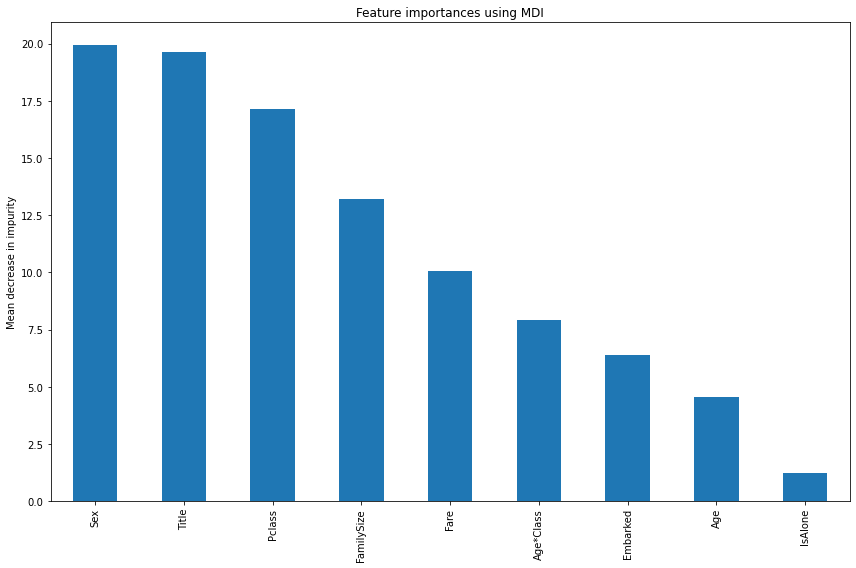

In [105]:
feats = pd.Series(feats)

fig, ax = plt.subplots()
feats.sort_values(ascending=False).plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

As we can see, the best accuracy has Random Forest model. For two best models, Random Forest and CatBoost we made feature importance plots, and in both cases three most important features was Title, Sex and Pclass, although Sex and Title was on the different places. The least important feature in both cases was IsAlone.

## Making Prediction

In [ ]:
test_answers = second_model_cv.predict(df_test)

In [ ]:
submission = pd.DataFrame([test_index, test_answers]).transpose()

In [ ]:
submission.columns = ['PassengerId', 'Survived']

In [ ]:
submission

In [ ]:
submission.to_csv('Submission', index=False)